###**Recommend Ecommerce Products - **

**Type 1:** Model-based collaborative filtering system based on customer's purchase history and ratings provided by other users who bought items similar items

**Type 2:** When a business is setting up its e-commerce website for the first time withou any product rating

In [19]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

Loading the rating dataset

In [20]:
amazon_ratings = pd.read_csv('./data/ratings.csv')
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


Checking the shape of the dataframe

In [21]:
amazon_ratings.shape

(2023070, 4)

Grouping the products by product id

In [22]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


Visualizing bar plot of most popular products

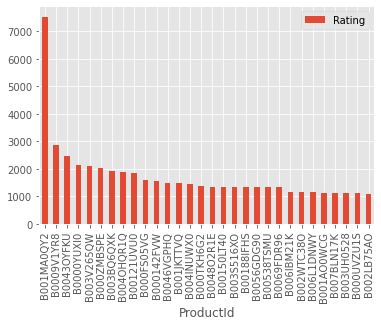

In [23]:
most_popular.head(30).plot(kind = "bar")

Utility Matrix : An utility matrix consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all the items in the list, hence, most of the values are unknown.

In [24]:
amazon_ratings_subset = amazon_ratings.head(10000) #to prevent memory overload
ratings_utility_matrix = amazon_ratings_subset.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,1304196046,1304196062,1304196070,1304196135,1304351475,1304482596,1304482634,1304482685,1304488608,1304495396,1304511073,1304511081,1304511111,130451112X,1304511138,1304511146,1304511154,1304622193,1304622223,1304622428,1304622452,1304622460,1304622622,1304622657,1304622665,...,B000052YMU,B000052YMV,B000052YMX,B000052YN5,B000052YN6,B000052YN7,B000052YN9,B000052YNA,B000052YNB,B000052YNE,B000052YOC,B000052YOG,B000052YOL,B000052YOM,B000052YOQ,B000052YOR,B000052YOS,B000052YOT,B000052YOU,B000052YOV,B000052YOX,B000052YOY,B000052YOZ,B000052YP0,B000052YP1,B000052YP3,B000052YP4,B000052YP6,B000052YP9,B000052YPC,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, the unknown values are filled with 0.

In [25]:
ratings_utility_matrix.shape

(9697, 886)

Transposing the matrix

In [26]:
X = ratings_utility_matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,A0870685EP51H0X8LFFU,A100AM334XZS3V,A100GYE1W4OXZ8,A100UD67AHFODS,A101GN97A47S1P,A10205RFE66H1R,A1029IITTU8289,A102LFZGD4MJXV,A1034GEUA8ZVFR,A103BJIOJSDJL1,A103FNP25GNMPH,A103PIRYKWQKR7,A103QH6R6A4FT1,A103QUZ016BQNJ,A103U3KR4L2ZXT,A1041053SID37WN8GTT8,A104CBA4A4HYOF,A104D62WJII6KP,A105C73RQ4YGCW,A1087Y8RJ4D422,A108HJD2ESJXUY,A108JE8E0CK1G3,A108LMMYNGL89M,A108V4O9Z78DB5,A10BXWWQPUDNCW,A10BZV61MNLBZD,A10C03UY4QEHJT,A10FEMX3ROQPTD,A10FXC2G4J7V6J,A10G0QS2B1S9J2,...,AZD8DMTDUVUDL,AZDHBUN122II4,AZDIZ674B4GVL,AZEIM64I6C7WW,AZG4Z8O02E9H4,AZG82XLVC98Y3,AZGGH4GS18RUN,AZGNXVV2ENZW8,AZHA72ZW5U8,AZJ8PVOKAJS5,AZJSE6RVOUU0E,AZKWPIG6RXKNG,AZLE2XFH3JUNG,AZLXFHIJ0J4VQ,AZLYAJ8XE443K,AZM0CLX6A5FFB,AZM3MWNYYPF0J,AZMS0XGWN43LW,AZMW54GPQ0WTQ,AZMWU0SO3H0DG,AZN3PS2PIZV06,AZNACMHVBRB5P,AZNOO10AO8G8V,AZP9CW7C6G8XO,AZPJ8ZDUN5HY8,AZSCK9QG6SMSB,AZSY5LHJ6LN7F,AZUFBU43ILNPC,AZUOLPXIGPG5O,AZW0RIARTTWWR,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0205616461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0558925278,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
X.shape

(886, 9697)

Decomposing the matrix

In [28]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

Correlation Matrix

In [29]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

Isolating Product ID # 6117036094 from the Correlation Matrix (random)

In [30]:
i = "6117036094"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [31]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(886,)

Recommending top 10 highly correlated products in sequence

In [32]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['1304139212',
 '1304139220',
 '130414643X',
 '130414674X',
 '1304174778',
 '1304174867',
 '1304174905',
 '1304196046',
 '1304196062']

Product Id # Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.

###Recommendation System Part 2:

For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.

Item to item based recommendation system based on product description
Applicable when business is setting up its E-commerce website for the first time

In [33]:
product_descriptions = pd.read_csv('./data/product_descriptions.csv')
product_descriptions.shape

(124428, 2)

Checking for missing values

In [34]:
product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


Product descriptions

In [35]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]

product_descriptions1["product_description"].head(10)

0    Not only do angles make joints stronger, they ...
1    BEHR Premium Textured DECKOVER is an innovativ...
2    Classic architecture meets contemporary design...
3    The Grape Solar 265-Watt Polycrystalline PV So...
4    Update your bathroom with the Delta Vero Singl...
5    Achieving delicious results is almost effortle...
6    The Quantum Adjustable 2-Light LED Black Emerg...
7    The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8    Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9    Valley View Industries Metal Stakes (4-Pack) a...
Name: product_description, dtype: object

Feature extraction from product descriptions
Converting the text in product description into numerical data for analysis

In [36]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])
X1

<500x8932 sparse matrix of type '<class 'numpy.float64'>'
	with 34817 stored elements in Compressed Sparse Row format>

Visualizing product clusters in subset of data

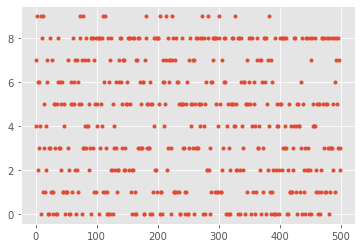

In [37]:
# Fitting K-Means to the dataset

X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [38]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Output
Recommendation of product based on the current product selected by user.
To recommend related product based on, Frequently bought together.

Top words in each cluster based on product description

In [39]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 tool
 metal
 20
 volt
 power
 drill
 impact
 concrete
 use
 gauge
Cluster 1:
 water
 easy
 design
 spray
 helps
 stainless
 faucet
 tank
 steel
 handle
Cluster 2:
 cutting
 saw
 blade
 tree
 steel
 pruner
 easy
 tooth
 pole
 blades
Cluster 3:
 wall
 piece
 finish
 color
 tile
 ft
 recommended
 resistant
 outdoor
 design
Cluster 4:
 post
 wood
 100
 cedar
 ft
 red
 outdoor
 dog
 recycled
 decks
Cluster 5:
 air
 power
 ft
 light
 fan
 control
 cooling
 installation
 cooking
 window
Cluster 6:
 storage
 shelves
 cabinet
 adjustable
 shelf
 room
 metal
 finish
 32
 nickel
Cluster 7:
 insulation
 bamboo
 galvanized
 quality
 steel
 outdoor
 home
 products
 glass
 ecotouch
Cluster 8:
 ladder
 aluminum
 attic
 frame
 easy
 lb
 ft
 screen
 window
 cover
Cluster 9:
 door
 wood
 double
 proposition
 nbsp
 residents
 california
 65
 painted
 core


Predicting clusters based on key search words

In [40]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

Keyword : cutting tool

In [41]:
show_recommendations("cutting tool")

Cluster 2:
 cutting
 saw
 blade
 tree
 steel
 pruner
 easy
 tooth
 pole
 blades


Keyword : spray paint

In [42]:
show_recommendations("spray paint")

Cluster 1:
 water
 easy
 design
 spray
 helps
 stainless
 faucet
 tank
 steel
 handle


In case a word appears in multiple clusters, the algorithm chooses the cluster with the highest frequency of occurance of the word.

In [43]:
show_recommendations("water")

Cluster 1:
 water
 easy
 design
 spray
 helps
 stainless
 faucet
 tank
 steel
 handle
